In [1]:
from google.colab import drive
import sys
import os

# Montar Google Drive
drive.mount('/content/drive')

# Definir rutas base y repo
BASE_PATH = '/content/drive/MyDrive/Tesis'
REPO_NAME = 'Tesis_NN'
REPO_PATH = os.path.join(BASE_PATH, REPO_NAME)

# Agregar repo al path de Python para imports
if REPO_PATH not in sys.path:
    sys.path.append(REPO_PATH)

# Cambiar directorio actual al repo (para comandos git)
os.chdir(REPO_PATH)

print(f"Drive montado. Carpeta repo seteada en: {REPO_PATH}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive montado. Carpeta repo seteada en: /content/drive/MyDrive/Tesis/Tesis_NN


In [2]:
# ───────────────────────────────────────────────────────────────────────────────
# 📦 Standard Library Imports
# ───────────────────────────────────────────────────────────────────────────────
import os
from pathlib import Path    # For file and directory manipulation
import sys                  # To modify Python path for custom module imports
import csv                  # To handle CSV file reading/writing
import random               # For generating random numbers
import numpy as np          # Numerical operations and array handling
import pandas as pd         # DataFrame handling for structured data
import matplotlib.pyplot as plt  # Plotting and visualization
import time


# ───────────────────────────────────────────────────────────────────────────────
# 🌍 Third-Party Library Imports
# ───────────────────────────────────────────────────────────────────────────────
import torch                # PyTorch: deep learning framework
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms.functional as functional_transforms

# ───────────────────────────────────────────────────────────────────────────────
# 🧩 Custom Project Modules
# ───────────────────────────────────────────────────────────────────────────────

# Add custom project folder to system path to enable local module imports
sys.path.append('C:/Users/nnobi/Desktop/FIUBA/Tesis/Project')

# Import common training routines
from project_package.utils import train_common_routines as tcr

# Import model
from project_package.conv_net.ConvNet_model import SRCNN

# Import dataset manager
from project_package.dataset_manager.tensor_images_dataset import Tensor_images_dataset

# Import Sentinel-2 to Venus preprocessing utilities
from project_package.data_processing import sen2venus_routines as s2v

# Import general utility functions
from project_package.utils import utils as utils


In [3]:
#Select GPUs is they are available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ",device)

Device:  cuda


In [5]:
#Dataset
dataset = 'my_dataset3'

#Parameters for training
patched_images = 'no'
model_selection='large'
epochs = 200 # number of epochs to train the SRCNN model for
lr = 0.00001 # the learning rate
batch_size = 32
patch_size=64
stride=48
scale_value=10000

#Split porcentages for training, validation and testing
train_data_ratio=0.95
validation_data_ratio=0.04
test_data_ratio= 1 - train_data_ratio - validation_data_ratio


#Training data folder generated by load_files_tensor_data. It is in .pt files ready to be loaded
data_folder = 'C:/Users/nnobi/Desktop/FIUBA/Tesis/Project/datasets/' + dataset
data_folder = os.path.join(REPO_PATH,'datasets',dataset)
#Folder where results will be save
results_folder = os.path.join(REPO_PATH,'results','Conv_Net')
# Crear carpeta de resultados si no existe
os.makedirs(results_folder, exist_ok=True)

# Files to be saved
# Archivos a guardar
loss_png_file = os.path.join(results_folder, f"loss_lr={lr}_batch_size={batch_size}_model={model_selection}_patched_images={patched_images}.png")
psnr_png_file = os.path.join(results_folder, f"psnr_lr={lr}_batch_size={batch_size}_model={model_selection}_patched_images={patched_images}.png")
final_model_pth_file = os.path.join(results_folder, f"model_lr={lr}_batch_size={batch_size}_model={model_selection}_patched_images={patched_images}.pth")
file_training_losses = os.path.join(results_folder, f"training_losses_lr={lr}_batch_size={batch_size}_model={model_selection}_patched_images={patched_images}.csv")


In [6]:
#Model initialization
model = SRCNN(model_selection).to(device)
print("The model: ")
print(model)
# Get parameter count
model.count_parameters()
print(f"Total Parameters: {model.total_params:,}")
print(f"Trainable Parameters: {model.trainable_params:,}")
#Load model on multiple GPUs if available
model=tcr.multi_GPU_training(model)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)


if patched_images=="no":
    file_path_low_res = os.path.join(data_folder,'10m.pt')
    file_path_high_res= os.path.join(data_folder,'05m.pt')

    #Initialize dataset for training
    dataset = Tensor_images_dataset(file_path_low_res,file_path_high_res)

    #Split data
    train_data, val_data, test_data = tcr.data_split(dataset,train_data_ratio, validation_data_ratio, test_data_ratio)

    # Create DataLoader (ensures batch-wise loading)

    dataloader_train = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    dataloader_val = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    dataloader_test = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    print("Training with unpatched images")
elif patched_images=="yes":
    #Create DataLoader for train data
    file_path_low_res_train=data_folder/f'train_data_low_res_patched_patch_size={patch_size}_stride={stride}.pt'
    file_path_high_res_train=data_folder/f'train_data_high_res_patched_patch_size={patch_size}_stride={stride}.pt'
    dataset_train = Tensor_images_dataset(file_path_low_res_train,file_path_high_res_train)
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

    #Create DataLoader for validation data
    file_path_low_res_val=data_folder/f'val_data_low_res_patched_patch_size={patch_size}_stride={stride}.pt'
    file_path_high_res_val=data_folder/f'val_data_high_res_patched_patch_size={patch_size}_stride={stride}.pt'
    dataset_val = Tensor_images_dataset(file_path_low_res_val,file_path_high_res_val)
    dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

    print("Training with patched images")


The model: 
SRCNN(
  (conv1): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4), padding_mode=replicate)
  (relu1): ReLU(inplace=True)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
  (relu2): ReLU(inplace=True)
  (conv3): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
  (relu3): ReLU(inplace=True)
  (conv4): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
)
Total Parameters: 427,139
Trainable Parameters: 427,139
Model training to be done in only one GPU!
Number of training samples: 123
Number of validation samples: 5
Number of testing samples: 1
Training with unpatched images


Epoch 1 of 200


100%|██████████| 1/1 [00:00<00:00,  7.01it/s]


Train PSNR: 4.230
Val PSNR: 4.795
Checkpoint saved at epoch 0
Epoch 2 of 200


100%|██████████| 1/1 [00:00<00:00,  7.14it/s]

Train PSNR: 5.419
Val PSNR: 5.599
Epoch 3 of 200



100%|██████████| 1/1 [00:00<00:00,  6.03it/s]

Train PSNR: 5.734
Val PSNR: 5.598
Epoch 4 of 200



100%|██████████| 1/1 [00:00<00:00,  7.18it/s]

Train PSNR: 5.728
Val PSNR: 5.598
Epoch 5 of 200



100%|██████████| 1/1 [00:00<00:00,  6.94it/s]

Train PSNR: 5.728
Val PSNR: 5.598
Epoch 6 of 200



100%|██████████| 1/1 [00:00<00:00,  6.87it/s]


Train PSNR: 5.727
Val PSNR: 5.598
Checkpoint saved at epoch 5
Epoch 7 of 200


100%|██████████| 1/1 [00:00<00:00,  6.71it/s]


Train PSNR: 5.727
Val PSNR: 5.598
Epoch 8 of 200


100%|██████████| 1/1 [00:00<00:00,  6.73it/s]

Train PSNR: 5.726
Val PSNR: 5.599
Epoch 9 of 200



100%|██████████| 1/1 [00:00<00:00,  6.92it/s]

Train PSNR: 5.720
Val PSNR: 5.601
Epoch 10 of 200



100%|██████████| 1/1 [00:00<00:00,  7.06it/s]


Train PSNR: 5.723
Val PSNR: 5.605
Epoch 11 of 200


100%|██████████| 1/1 [00:00<00:00,  6.77it/s]


Train PSNR: 5.726
Val PSNR: 5.613
Checkpoint saved at epoch 10
Epoch 12 of 200


100%|██████████| 1/1 [00:00<00:00,  6.27it/s]

Train PSNR: 5.726
Val PSNR: 5.625
Epoch 13 of 200



100%|██████████| 1/1 [00:00<00:00,  6.85it/s]


Train PSNR: 5.735
Val PSNR: 5.671
Epoch 14 of 200


100%|██████████| 1/1 [00:00<00:00,  7.12it/s]

Train PSNR: 5.747
Val PSNR: 5.837
Epoch 15 of 200



100%|██████████| 1/1 [00:00<00:00,  6.89it/s]

Train PSNR: 5.775
Val PSNR: 5.995
Epoch 16 of 200



100%|██████████| 1/1 [00:00<00:00,  5.46it/s]


Train PSNR: 5.824
Val PSNR: 6.078
Checkpoint saved at epoch 15
Epoch 17 of 200


100%|██████████| 1/1 [00:00<00:00,  6.83it/s]


Train PSNR: 5.842
Val PSNR: 6.153
Epoch 18 of 200


100%|██████████| 1/1 [00:00<00:00,  6.79it/s]


Train PSNR: 5.936
Val PSNR: 6.762
Epoch 19 of 200


100%|██████████| 1/1 [00:00<00:00,  6.68it/s]


Train PSNR: 6.601
Val PSNR: 7.449
Epoch 20 of 200


100%|██████████| 1/1 [00:00<00:00,  5.70it/s]

Train PSNR: 6.641
Val PSNR: 7.319
Epoch 21 of 200



100%|██████████| 1/1 [00:00<00:00,  6.92it/s]


Train PSNR: 6.597
Val PSNR: 7.319
Checkpoint saved at epoch 20
Epoch 22 of 200


100%|██████████| 1/1 [00:00<00:00,  6.79it/s]


Train PSNR: 6.617
Val PSNR: 7.319
Epoch 23 of 200


100%|██████████| 1/1 [00:00<00:00,  6.82it/s]


Train PSNR: 6.598
Val PSNR: 7.319
Epoch 24 of 200


100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


Train PSNR: 6.610
Val PSNR: 7.319
Epoch 25 of 200


100%|██████████| 1/1 [00:00<00:00,  6.37it/s]

Train PSNR: 6.616
Val PSNR: 7.319
Epoch 26 of 200



100%|██████████| 1/1 [00:00<00:00,  7.06it/s]


Train PSNR: 6.596
Val PSNR: 7.319
Checkpoint saved at epoch 25
Epoch 27 of 200


100%|██████████| 1/1 [00:00<00:00,  6.57it/s]

Train PSNR: 6.598
Val PSNR: 7.319
Epoch 28 of 200



100%|██████████| 1/1 [00:00<00:00,  4.32it/s]

Train PSNR: 6.624
Val PSNR: 7.319
Epoch 29 of 200



100%|██████████| 1/1 [00:00<00:00,  5.41it/s]

Train PSNR: 6.591
Val PSNR: 7.333
Epoch 30 of 200



100%|██████████| 1/1 [00:00<00:00,  7.00it/s]

Train PSNR: 6.636
Val PSNR: 7.483
Epoch 31 of 200



100%|██████████| 1/1 [00:00<00:00,  6.80it/s]


Train PSNR: 6.768
Val PSNR: 7.633
Checkpoint saved at epoch 30
Epoch 32 of 200


100%|██████████| 1/1 [00:00<00:00,  5.45it/s]

Train PSNR: 6.812
Val PSNR: 7.680
Epoch 33 of 200



100%|██████████| 1/1 [00:00<00:00,  6.71it/s]


Train PSNR: 6.788
Val PSNR: 7.616
Epoch 34 of 200


100%|██████████| 1/1 [00:00<00:00,  6.58it/s]


Train PSNR: 6.732
Val PSNR: 7.565
Epoch 35 of 200


100%|██████████| 1/1 [00:00<00:00,  6.53it/s]

Train PSNR: 6.732
Val PSNR: 7.554
Epoch 36 of 200



100%|██████████| 1/1 [00:00<00:00,  5.54it/s]


Train PSNR: 6.738
Val PSNR: 7.560
Checkpoint saved at epoch 35
Epoch 37 of 200


100%|██████████| 1/1 [00:00<00:00,  6.95it/s]


Train PSNR: 6.753
Val PSNR: 7.555
Epoch 38 of 200


100%|██████████| 1/1 [00:00<00:00,  6.90it/s]


Train PSNR: 6.767
Val PSNR: 7.567
Epoch 39 of 200


100%|██████████| 1/1 [00:00<00:00,  6.73it/s]


Train PSNR: 6.790
Val PSNR: 7.590
Epoch 40 of 200


100%|██████████| 1/1 [00:00<00:00,  6.04it/s]

Train PSNR: 6.805
Val PSNR: 7.639
Epoch 41 of 200



100%|██████████| 1/1 [00:00<00:00,  6.69it/s]


Train PSNR: 6.858
Val PSNR: 7.699
Checkpoint saved at epoch 40
Epoch 42 of 200


100%|██████████| 1/1 [00:00<00:00,  6.45it/s]

Train PSNR: 6.910
Val PSNR: 7.758
Epoch 43 of 200



100%|██████████| 1/1 [00:00<00:00,  7.06it/s]


Train PSNR: 6.948
Val PSNR: 7.787
Epoch 44 of 200


100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


Train PSNR: 6.962
Val PSNR: 7.796
Epoch 45 of 200


100%|██████████| 1/1 [00:00<00:00,  6.51it/s]


Train PSNR: 6.985
Val PSNR: 7.763
Epoch 46 of 200


100%|██████████| 1/1 [00:00<00:00,  6.73it/s]


Train PSNR: 6.981
Val PSNR: 7.826
Checkpoint saved at epoch 45
Epoch 47 of 200


100%|██████████| 1/1 [00:00<00:00,  6.59it/s]


Train PSNR: 7.041
Val PSNR: 7.875
Epoch 48 of 200


100%|██████████| 1/1 [00:00<00:00,  5.40it/s]

Train PSNR: 7.082
Val PSNR: 7.902
Epoch 49 of 200



100%|██████████| 1/1 [00:00<00:00,  6.56it/s]

Train PSNR: 7.127
Val PSNR: 7.913
Epoch 50 of 200



100%|██████████| 1/1 [00:00<00:00,  6.36it/s]

Train PSNR: 7.130
Val PSNR: 7.945
Epoch 51 of 200



100%|██████████| 1/1 [00:00<00:00,  6.68it/s]

Train PSNR: 7.168
Val PSNR: 7.963
Checkpoint saved at epoch 50
Epoch 52 of 200



100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


Train PSNR: 7.226
Val PSNR: 7.997
Epoch 53 of 200


100%|██████████| 1/1 [00:00<00:00,  6.98it/s]


Train PSNR: 7.242
Val PSNR: 7.997
Epoch 54 of 200


100%|██████████| 1/1 [00:00<00:00,  6.62it/s]

Train PSNR: 7.270
Val PSNR: 8.030
Epoch 55 of 200



100%|██████████| 1/1 [00:00<00:00,  6.08it/s]

Train PSNR: 7.277
Val PSNR: 8.026
Epoch 56 of 200



100%|██████████| 1/1 [00:00<00:00,  5.39it/s]


Train PSNR: 7.306
Val PSNR: 8.046
Checkpoint saved at epoch 55
Epoch 57 of 200


100%|██████████| 1/1 [00:00<00:00,  6.65it/s]

Train PSNR: 7.345
Val PSNR: 8.090
Epoch 58 of 200



100%|██████████| 1/1 [00:00<00:00,  6.76it/s]


Train PSNR: 7.375
Val PSNR: 8.102
Epoch 59 of 200


100%|██████████| 1/1 [00:00<00:00,  6.41it/s]

Train PSNR: 7.385
Val PSNR: 8.106
Epoch 60 of 200



100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


Train PSNR: 7.392
Val PSNR: 8.113
Epoch 61 of 200


100%|██████████| 1/1 [00:00<00:00,  6.70it/s]


Train PSNR: 7.414
Val PSNR: 8.135
Checkpoint saved at epoch 60
Epoch 62 of 200


100%|██████████| 1/1 [00:00<00:00,  6.63it/s]


Train PSNR: 7.428
Val PSNR: 8.125
Epoch 63 of 200


100%|██████████| 1/1 [00:00<00:00,  6.82it/s]

Train PSNR: 7.441
Val PSNR: 8.100
Epoch 64 of 200



100%|██████████| 1/1 [00:00<00:00,  6.10it/s]

Train PSNR: 7.411
Val PSNR: 8.085
Epoch 65 of 200



100%|██████████| 1/1 [00:00<00:00,  6.67it/s]


Train PSNR: 7.419
Val PSNR: 8.142
Epoch 66 of 200


100%|██████████| 1/1 [00:00<00:00,  6.72it/s]


Train PSNR: 7.468
Val PSNR: 8.174
Checkpoint saved at epoch 65
Epoch 67 of 200


100%|██████████| 1/1 [00:00<00:00,  6.67it/s]

Train PSNR: 7.500
Val PSNR: 8.194
Epoch 68 of 200



100%|██████████| 1/1 [00:00<00:00,  5.03it/s]

Train PSNR: 7.517
Val PSNR: 8.195
Epoch 69 of 200



100%|██████████| 1/1 [00:00<00:00,  6.77it/s]

Train PSNR: 7.540
Val PSNR: 8.216
Epoch 70 of 200



100%|██████████| 1/1 [00:00<00:00,  6.92it/s]


Train PSNR: 7.564
Val PSNR: 8.213
Epoch 71 of 200


100%|██████████| 1/1 [00:00<00:00,  6.60it/s]


Train PSNR: 7.561
Val PSNR: 8.210
Checkpoint saved at epoch 70
Epoch 72 of 200


100%|██████████| 1/1 [00:00<00:00,  5.47it/s]

Train PSNR: 7.549
Val PSNR: 8.238
Epoch 73 of 200



100%|██████████| 1/1 [00:00<00:00,  6.67it/s]

Train PSNR: 7.591
Val PSNR: 8.246
Epoch 74 of 200



100%|██████████| 1/1 [00:00<00:00,  6.61it/s]

Train PSNR: 7.590
Val PSNR: 8.228
Epoch 75 of 200



100%|██████████| 1/1 [00:00<00:00,  6.91it/s]


Train PSNR: 7.584
Val PSNR: 8.265
Epoch 76 of 200


100%|██████████| 1/1 [00:00<00:00,  5.85it/s]


Train PSNR: 7.636
Val PSNR: 8.283
Checkpoint saved at epoch 75
Epoch 77 of 200


100%|██████████| 1/1 [00:00<00:00,  6.65it/s]


Train PSNR: 7.641
Val PSNR: 8.296
Epoch 78 of 200


100%|██████████| 1/1 [00:00<00:00,  6.49it/s]

Train PSNR: 7.652
Val PSNR: 8.314
Epoch 79 of 200



100%|██████████| 1/1 [00:00<00:00,  6.46it/s]

Train PSNR: 7.651
Val PSNR: 8.291
Epoch 80 of 200



100%|██████████| 1/1 [00:00<00:00,  5.67it/s]

Train PSNR: 7.669
Val PSNR: 8.315
Epoch 81 of 200



100%|██████████| 1/1 [00:00<00:00,  6.63it/s]


Train PSNR: 7.680
Val PSNR: 8.331
Checkpoint saved at epoch 80
Epoch 82 of 200


100%|██████████| 1/1 [00:00<00:00,  6.73it/s]


Train PSNR: 7.685
Val PSNR: 8.337
Epoch 83 of 200


100%|██████████| 1/1 [00:00<00:00,  6.87it/s]


Train PSNR: 7.687
Val PSNR: 8.319
Epoch 84 of 200


100%|██████████| 1/1 [00:00<00:00,  6.42it/s]

Train PSNR: 7.671
Val PSNR: 8.317
Epoch 85 of 200



100%|██████████| 1/1 [00:00<00:00,  6.85it/s]

Train PSNR: 7.692
Val PSNR: 8.356
Epoch 86 of 200



100%|██████████| 1/1 [00:00<00:00,  6.40it/s]

Train PSNR: 7.718
Val PSNR: 8.353
Checkpoint saved at epoch 85
Epoch 87 of 200



100%|██████████| 1/1 [00:00<00:00,  5.80it/s]

Train PSNR: 7.720
Val PSNR: 8.356
Epoch 88 of 200



100%|██████████| 1/1 [00:00<00:00,  6.75it/s]


Train PSNR: 7.728
Val PSNR: 8.322
Epoch 89 of 200


100%|██████████| 1/1 [00:00<00:00,  6.24it/s]

Train PSNR: 7.708
Val PSNR: 8.333
Epoch 90 of 200



100%|██████████| 1/1 [00:00<00:00,  6.66it/s]


Train PSNR: 7.713
Val PSNR: 8.363
Epoch 91 of 200


100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


Train PSNR: 7.724
Val PSNR: 8.386
Checkpoint saved at epoch 90
Epoch 92 of 200


100%|██████████| 1/1 [00:00<00:00,  6.44it/s]

Train PSNR: 7.746
Val PSNR: 8.378
Epoch 93 of 200



100%|██████████| 1/1 [00:00<00:00,  6.42it/s]

Train PSNR: 7.763
Val PSNR: 8.388
Epoch 94 of 200



100%|██████████| 1/1 [00:00<00:00,  5.75it/s]

Train PSNR: 7.757
Val PSNR: 8.393
Epoch 95 of 200



100%|██████████| 1/1 [00:00<00:00,  5.56it/s]

Train PSNR: 7.769
Val PSNR: 8.414
Epoch 96 of 200



100%|██████████| 1/1 [00:00<00:00,  6.59it/s]

Train PSNR: 7.776
Val PSNR: 8.362
Checkpoint saved at epoch 95
Epoch 97 of 200



100%|██████████| 1/1 [00:00<00:00,  6.47it/s]

Train PSNR: 7.725
Val PSNR: 8.363
Epoch 98 of 200



100%|██████████| 1/1 [00:00<00:00,  7.06it/s]


Train PSNR: 7.754
Val PSNR: 8.353
Epoch 99 of 200


100%|██████████| 1/1 [00:00<00:00,  5.37it/s]

Train PSNR: 7.741
Val PSNR: 8.390
Epoch 100 of 200



100%|██████████| 1/1 [00:00<00:00,  7.05it/s]

Train PSNR: 7.765
Val PSNR: 8.415
Epoch 101 of 200



100%|██████████| 1/1 [00:00<00:00,  6.79it/s]


Train PSNR: 7.778
Val PSNR: 8.412
Checkpoint saved at epoch 100
Epoch 102 of 200


100%|██████████| 1/1 [00:00<00:00,  6.69it/s]


Train PSNR: 7.780
Val PSNR: 8.417
Epoch 103 of 200


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]

Train PSNR: 7.771
Val PSNR: 8.379
Epoch 104 of 200



100%|██████████| 1/1 [00:00<00:00,  6.52it/s]

Train PSNR: 7.764
Val PSNR: 8.378
Epoch 105 of 200



100%|██████████| 1/1 [00:00<00:00,  6.67it/s]


Train PSNR: 7.763
Val PSNR: 8.412
Epoch 106 of 200


100%|██████████| 1/1 [00:00<00:00,  6.77it/s]

Train PSNR: 7.815
Val PSNR: 8.431
Checkpoint saved at epoch 105
Epoch 107 of 200



100%|██████████| 1/1 [00:00<00:00,  6.01it/s]

Train PSNR: 7.815
Val PSNR: 8.420
Epoch 108 of 200



100%|██████████| 1/1 [00:00<00:00,  6.50it/s]

Train PSNR: 7.776
Val PSNR: 8.312
Epoch 109 of 200



100%|██████████| 1/1 [00:00<00:00,  6.45it/s]

Train PSNR: 7.751
Val PSNR: 8.380
Epoch 110 of 200



100%|██████████| 1/1 [00:00<00:00,  6.62it/s]


Train PSNR: 7.790
Val PSNR: 8.418
Epoch 111 of 200


100%|██████████| 1/1 [00:00<00:00,  5.74it/s]


Train PSNR: 7.799
Val PSNR: 8.421
Checkpoint saved at epoch 110
Epoch 112 of 200


100%|██████████| 1/1 [00:00<00:00,  6.52it/s]

Train PSNR: 7.837
Val PSNR: 8.435
Epoch 113 of 200



100%|██████████| 1/1 [00:00<00:00,  6.64it/s]


Train PSNR: 7.802
Val PSNR: 8.396
Epoch 114 of 200


100%|██████████| 1/1 [00:00<00:00,  6.53it/s]

Train PSNR: 7.800
Val PSNR: 8.417
Epoch 115 of 200



100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


Train PSNR: 7.813
Val PSNR: 8.433
Epoch 116 of 200


100%|██████████| 1/1 [00:00<00:00,  7.10it/s]


Train PSNR: 7.796
Val PSNR: 8.410
Checkpoint saved at epoch 115
Epoch 117 of 200


100%|██████████| 1/1 [00:00<00:00,  6.69it/s]


Train PSNR: 7.789
Val PSNR: 8.419
Epoch 118 of 200


100%|██████████| 1/1 [00:00<00:00,  6.88it/s]

Train PSNR: 7.814
Val PSNR: 8.426
Epoch 119 of 200



100%|██████████| 1/1 [00:00<00:00,  5.33it/s]

Train PSNR: 7.806
Val PSNR: 8.415
Epoch 120 of 200



100%|██████████| 1/1 [00:00<00:00,  6.65it/s]

Train PSNR: 7.796
Val PSNR: 8.413
Epoch 121 of 200



100%|██████████| 1/1 [00:00<00:00,  6.68it/s]


Train PSNR: 7.814
Val PSNR: 8.432
Checkpoint saved at epoch 120
Epoch 122 of 200


100%|██████████| 1/1 [00:00<00:00,  6.59it/s]


Train PSNR: 7.834
Val PSNR: 8.441
Epoch 123 of 200


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


Train PSNR: 7.832
Val PSNR: 8.441
Epoch 124 of 200


100%|██████████| 1/1 [00:00<00:00,  6.63it/s]


Train PSNR: 7.831
Val PSNR: 8.410
Epoch 125 of 200


100%|██████████| 1/1 [00:00<00:00,  6.71it/s]


Train PSNR: 7.764
Val PSNR: 8.368
Epoch 126 of 200


100%|██████████| 1/1 [00:00<00:00,  6.51it/s]

Train PSNR: 7.790
Val PSNR: 8.429
Checkpoint saved at epoch 125
Epoch 127 of 200



100%|██████████| 1/1 [00:00<00:00,  4.83it/s]

Train PSNR: 7.844
Val PSNR: 8.451
Epoch 128 of 200



100%|██████████| 1/1 [00:00<00:00,  6.56it/s]


Train PSNR: 7.835
Val PSNR: 8.403
Epoch 129 of 200


100%|██████████| 1/1 [00:00<00:00,  6.57it/s]

Train PSNR: 7.786
Val PSNR: 8.362
Epoch 130 of 200



100%|██████████| 1/1 [00:00<00:00,  6.66it/s]


Train PSNR: 7.814
Val PSNR: 8.438
Epoch 131 of 200


100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


Train PSNR: 7.864
Val PSNR: 8.450
Checkpoint saved at epoch 130
Epoch 132 of 200


100%|██████████| 1/1 [00:00<00:00,  6.99it/s]


Train PSNR: 7.854
Val PSNR: 8.451
Epoch 133 of 200


100%|██████████| 1/1 [00:00<00:00,  6.80it/s]

Train PSNR: 7.848
Val PSNR: 8.422
Epoch 134 of 200



100%|██████████| 1/1 [00:00<00:00,  6.66it/s]


Train PSNR: 7.835
Val PSNR: 8.410
Epoch 135 of 200


100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


Train PSNR: 7.824
Val PSNR: 8.421
Epoch 136 of 200


100%|██████████| 1/1 [00:00<00:00,  6.43it/s]

Train PSNR: 7.841
Val PSNR: 8.451
Checkpoint saved at epoch 135
Epoch 137 of 200



100%|██████████| 1/1 [00:00<00:00,  6.63it/s]


Train PSNR: 7.861
Val PSNR: 8.461
Epoch 138 of 200


100%|██████████| 1/1 [00:00<00:00,  6.73it/s]

Train PSNR: 7.856
Val PSNR: 8.413
Epoch 139 of 200



100%|██████████| 1/1 [00:00<00:00,  5.36it/s]


Train PSNR: 7.837
Val PSNR: 8.401
Epoch 140 of 200


100%|██████████| 1/1 [00:00<00:00,  6.44it/s]

Train PSNR: 7.836
Val PSNR: 8.438
Epoch 141 of 200



100%|██████████| 1/1 [00:00<00:00,  7.10it/s]


Train PSNR: 7.833
Val PSNR: 8.451
Checkpoint saved at epoch 140
Epoch 142 of 200


100%|██████████| 1/1 [00:00<00:00,  6.57it/s]


Train PSNR: 7.888
Val PSNR: 8.464
Epoch 143 of 200


100%|██████████| 1/1 [00:00<00:00,  5.61it/s]

Train PSNR: 7.865
Val PSNR: 8.440
Epoch 144 of 200



100%|██████████| 1/1 [00:00<00:00,  6.45it/s]

Train PSNR: 7.853
Val PSNR: 8.448
Epoch 145 of 200



100%|██████████| 1/1 [00:00<00:00,  6.63it/s]

Train PSNR: 7.860
Val PSNR: 8.465
Epoch 146 of 200



100%|██████████| 1/1 [00:00<00:00,  6.62it/s]

Train PSNR: 7.874
Val PSNR: 8.442
Checkpoint saved at epoch 145
Epoch 147 of 200



100%|██████████| 1/1 [00:00<00:00,  6.57it/s]

Train PSNR: 7.883
Val PSNR: 8.452
Epoch 148 of 200



100%|██████████| 1/1 [00:00<00:00,  6.74it/s]


Train PSNR: 7.876
Val PSNR: 8.469
Epoch 149 of 200


100%|██████████| 1/1 [00:00<00:00,  7.34it/s]


Train PSNR: 7.873
Val PSNR: 8.445
Epoch 150 of 200


100%|██████████| 1/1 [00:00<00:00,  6.57it/s]


Train PSNR: 7.864
Val PSNR: 8.449
Epoch 151 of 200


100%|██████████| 1/1 [00:00<00:00,  5.71it/s]


Train PSNR: 7.884
Val PSNR: 8.467
Checkpoint saved at epoch 150
Epoch 152 of 200


100%|██████████| 1/1 [00:00<00:00,  6.83it/s]

Train PSNR: 7.864
Val PSNR: 8.421
Epoch 153 of 200



100%|██████████| 1/1 [00:00<00:00,  6.53it/s]

Train PSNR: 7.842
Val PSNR: 8.458
Epoch 154 of 200



100%|██████████| 1/1 [00:00<00:00,  6.42it/s]

Train PSNR: 7.891
Val PSNR: 8.473
Epoch 155 of 200



100%|██████████| 1/1 [00:00<00:00,  6.65it/s]

Train PSNR: 7.883
Val PSNR: 8.472
Epoch 156 of 200



100%|██████████| 1/1 [00:00<00:00,  6.30it/s]

Train PSNR: 7.878
Val PSNR: 8.456
Checkpoint saved at epoch 155
Epoch 157 of 200



100%|██████████| 1/1 [00:00<00:00,  5.38it/s]

Train PSNR: 7.889
Val PSNR: 8.452
Epoch 158 of 200



100%|██████████| 1/1 [00:00<00:00,  5.64it/s]

Train PSNR: 7.886
Val PSNR: 8.477
Epoch 159 of 200



100%|██████████| 1/1 [00:00<00:00,  6.88it/s]


Train PSNR: 7.912
Val PSNR: 8.461
Epoch 160 of 200


100%|██████████| 1/1 [00:00<00:00,  6.50it/s]

Train PSNR: 7.897
Val PSNR: 8.455
Epoch 161 of 200



100%|██████████| 1/1 [00:00<00:00,  6.90it/s]

Train PSNR: 7.904
Val PSNR: 8.481
Checkpoint saved at epoch 160
Epoch 162 of 200



100%|██████████| 1/1 [00:00<00:00,  5.05it/s]

Train PSNR: 7.902
Val PSNR: 8.485
Epoch 163 of 200



100%|██████████| 1/1 [00:00<00:00,  6.44it/s]

Train PSNR: 7.902
Val PSNR: 8.448
Epoch 164 of 200



100%|██████████| 1/1 [00:00<00:00,  6.91it/s]

Train PSNR: 7.862
Val PSNR: 8.452
Epoch 165 of 200



100%|██████████| 1/1 [00:00<00:00,  6.87it/s]

Train PSNR: 7.895
Val PSNR: 8.474
Epoch 166 of 200



100%|██████████| 1/1 [00:00<00:00,  4.86it/s]

Train PSNR: 7.892
Val PSNR: 8.472
Checkpoint saved at epoch 165
Epoch 167 of 200



100%|██████████| 1/1 [00:00<00:00,  6.60it/s]


Train PSNR: 7.911
Val PSNR: 8.467
Epoch 168 of 200


100%|██████████| 1/1 [00:00<00:00,  6.61it/s]

Train PSNR: 7.908
Val PSNR: 8.487
Epoch 169 of 200



100%|██████████| 1/1 [00:00<00:00,  6.78it/s]

Train PSNR: 7.920
Val PSNR: 8.493
Epoch 170 of 200



100%|██████████| 1/1 [00:00<00:00,  5.51it/s]

Train PSNR: 7.921
Val PSNR: 8.486
Epoch 171 of 200



100%|██████████| 1/1 [00:00<00:00,  6.72it/s]

Train PSNR: 7.913
Val PSNR: 8.478
Checkpoint saved at epoch 170
Epoch 172 of 200



100%|██████████| 1/1 [00:00<00:00,  6.66it/s]


Train PSNR: 7.870
Val PSNR: 8.414
Epoch 173 of 200


100%|██████████| 1/1 [00:00<00:00,  6.89it/s]

Train PSNR: 7.899
Val PSNR: 8.483
Epoch 174 of 200



100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

Train PSNR: 7.924
Val PSNR: 8.496
Epoch 175 of 200



100%|██████████| 1/1 [00:00<00:00,  6.54it/s]


Train PSNR: 7.924
Val PSNR: 8.481
Epoch 176 of 200


100%|██████████| 1/1 [00:00<00:00,  6.86it/s]

Train PSNR: 7.905
Val PSNR: 8.473
Checkpoint saved at epoch 175
Epoch 177 of 200



100%|██████████| 1/1 [00:00<00:00,  6.73it/s]

Train PSNR: 7.900
Val PSNR: 8.474
Epoch 178 of 200



100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


Train PSNR: 7.915
Val PSNR: 8.487
Epoch 179 of 200


100%|██████████| 1/1 [00:00<00:00,  6.53it/s]

Train PSNR: 7.931
Val PSNR: 8.482
Epoch 180 of 200



100%|██████████| 1/1 [00:00<00:00,  6.48it/s]

Train PSNR: 7.887
Val PSNR: 8.423
Epoch 181 of 200



100%|██████████| 1/1 [00:00<00:00,  6.66it/s]

Train PSNR: 7.930
Val PSNR: 8.484
Checkpoint saved at epoch 180
Epoch 182 of 200



100%|██████████| 1/1 [00:00<00:00,  5.00it/s]

Train PSNR: 7.958
Val PSNR: 8.509
Epoch 183 of 200



100%|██████████| 1/1 [00:00<00:00,  6.43it/s]

Train PSNR: 7.947
Val PSNR: 8.505
Epoch 184 of 200



100%|██████████| 1/1 [00:00<00:00,  6.70it/s]


Train PSNR: 7.944
Val PSNR: 8.468
Epoch 185 of 200


100%|██████████| 1/1 [00:00<00:00,  6.45it/s]

Train PSNR: 7.930
Val PSNR: 8.506
Epoch 186 of 200



100%|██████████| 1/1 [00:00<00:00,  5.13it/s]

Train PSNR: 7.935
Val PSNR: 8.504
Checkpoint saved at epoch 185
Epoch 187 of 200



100%|██████████| 1/1 [00:00<00:00,  6.70it/s]


Train PSNR: 7.960
Val PSNR: 8.507
Epoch 188 of 200


100%|██████████| 1/1 [00:00<00:00,  6.04it/s]

Train PSNR: 7.945
Val PSNR: 8.496
Epoch 189 of 200



100%|██████████| 1/1 [00:00<00:00,  6.45it/s]

Train PSNR: 7.927
Val PSNR: 8.482
Epoch 190 of 200



100%|██████████| 1/1 [00:00<00:00,  4.84it/s]

Train PSNR: 7.937
Val PSNR: 8.511
Epoch 191 of 200



100%|██████████| 1/1 [00:00<00:00,  6.88it/s]


Train PSNR: 7.964
Val PSNR: 8.509
Checkpoint saved at epoch 190
Epoch 192 of 200


100%|██████████| 1/1 [00:00<00:00,  6.24it/s]

Train PSNR: 7.956
Val PSNR: 8.492
Epoch 193 of 200



100%|██████████| 1/1 [00:00<00:00,  6.64it/s]

Train PSNR: 7.948
Val PSNR: 8.503
Epoch 194 of 200



100%|██████████| 1/1 [00:00<00:00,  4.99it/s]

Train PSNR: 7.937
Val PSNR: 8.512
Epoch 195 of 200



100%|██████████| 1/1 [00:00<00:00,  6.77it/s]

Train PSNR: 7.960
Val PSNR: 8.514
Epoch 196 of 200



100%|██████████| 1/1 [00:00<00:00,  5.94it/s]


Train PSNR: 7.971
Val PSNR: 8.510
Checkpoint saved at epoch 195
Epoch 197 of 200


100%|██████████| 1/1 [00:00<00:00,  7.13it/s]


Train PSNR: 7.951
Val PSNR: 8.490
Epoch 198 of 200


100%|██████████| 1/1 [00:00<00:00,  5.46it/s]

Train PSNR: 7.952
Val PSNR: 8.513
Epoch 199 of 200



100%|██████████| 1/1 [00:00<00:00,  6.35it/s]

Train PSNR: 7.981
Val PSNR: 8.515
Epoch 200 of 200



100%|██████████| 1/1 [00:00<00:00,  6.24it/s]


Train PSNR: 7.984
Val PSNR: 8.517
Finished training in: 11.106 minutes


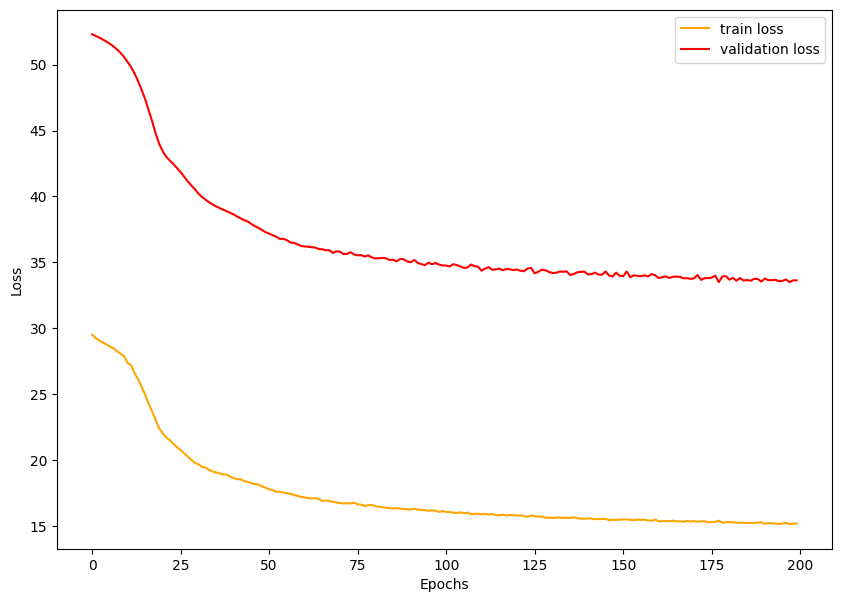

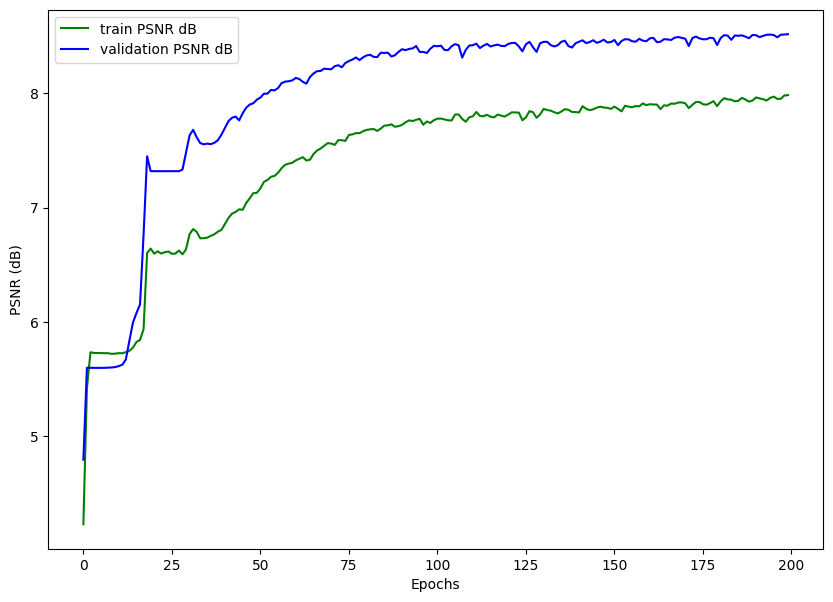

Saving model...


In [8]:
#Begin training
train_loss, val_loss = [], []
train_psnr, val_psnr = [], []
start = time.time()
for epoch in range(epochs):
    print(f"Epoch {epoch + 1} of {epochs}")
    train_epoch_loss, train_epoch_psnr = tcr.train(model, dataloader_train, optimizer, tcr.compute_loss_MSE, device)
    val_epoch_loss, val_epoch_psnr = tcr.validate(model, dataloader_val, epoch, tcr.compute_loss_MSE, device)
    print(f"Train PSNR: {train_epoch_psnr:.3f}")
    print(f"Val PSNR: {val_epoch_psnr:.3f}")
    train_loss.append(train_epoch_loss)
    train_psnr.append(train_epoch_psnr)
    val_loss.append(val_epoch_loss)
    val_psnr.append(val_epoch_psnr)
    if epoch % 5 == 0:
        tcr.save_checkpoint(epoch, model, optimizer, train_loss, filename=os.path.join(results_folder,"checkpoint_epoch_{epoch}_lr={lr}_batch_size={batch_size}_model={model_selection}_patched_images={patched_images}.pth"))
    with open(file_training_losses, mode="a", newline="") as file:
        writer = csv.writer(file)
        writer.writerow([train_epoch_loss, train_epoch_psnr, val_epoch_loss, val_epoch_psnr])
end = time.time()
print(f"Finished training in: {((end-start)/60):.3f} minutes")



#Plots training
plt.figure(figsize=(10, 7))
plt.plot(10*np.log10(train_loss), color='orange', label='train loss')
plt.plot(10*np.log10(val_loss), color='red', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
if os.path.exists(loss_png_file):
    os.remove(loss_png_file)
plt.savefig(loss_png_file)
plt.show()
# psnr plots
plt.figure(figsize=(10, 7))
plt.plot(train_psnr, color='green', label='train PSNR dB')
plt.plot(val_psnr, color='blue', label='validation PSNR dB')
plt.xlabel('Epochs')
plt.ylabel('PSNR (dB)')
plt.legend()
if os.path.exists(psnr_png_file):
    os.remove(psnr_png_file)
plt.savefig(psnr_png_file)
plt.show()

#Save the model to disk


print('Saving model...')
if os.path.exists(final_model_pth_file):
    os.remove(final_model_pth_file)
# If using DataParallel, remove it before saving
model = model.module if hasattr(model, "module") else model
torch.save(model.state_dict(), final_model_pth_file)
